# **Setup**
 
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, import the libraries needed to complete the code Professor Melnikov presented in the video.

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a Jupter notebook's cell
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, gensim, nltk, spacy
from collections import Counter
from gensim.models import FastText
from spacy.lang.en import English

np.set_printoptions(linewidth=10000, precision=2, edgeitems=10, suppress=True)
pd.set_option('max_rows', 100, 'max_columns', 1000, 'max_colwidth', 1000, 'precision', 2, 'display.max_rows', 4)
print(f'gensim {gensim.__version__}, numpy {np.__version__}, spacy {spacy.__version__}')

unit = lambda v: v / (v@v)**0.5      # stretch/shrink vector to make it unit length
CS = lambda x, y: unit(x) @ unit(y)  # cosine similarity is a dot product of standardized vectors

gensim 4.2.0, numpy 1.19.5, spacy 3.4.1


<hr style="border-top: 2px solid #606366; background: transparent;">


# **Review**
 
In this notebook, you'll train FastText vectors on the MSHA dataset. Then, you'll use similarities calculated from the FastText model to investigate similarity among documents and examine how this metric changes depending on how you train the model.

## **Train a FastText Model**

Use the MSHA dataset to train a FastText model.

In [2]:
dfAll = pd.read_csv('msha_2003-2018.zip', compression='zip').fillna('')        # replace NaN with empty string
dfAll['INJ_BODY_PART'] = dfAll['INJ_BODY_PART'].apply(lambda s: s.replace('/',', ').replace('(S)','').lower()) # clean up categories
dfAll['NARRATIVE'] = dfAll['NARRATIVE'].str.lower()                            # lower case narratives
dfAll['Len'] = dfAll['NARRATIVE'].apply(len)                                   # narrative's character length
dfDocs = dfAll.sort_values('Len', ascending=False).head(10000)[['NARRATIVE']]  # keep longest 10000 narratives

nlp = English(disable=['tagger', 'parser', 'ner'])  # disabled models save processing time in Spacy
tokenize = lambda text: [t.text.lower() for t in nlp(text)]  # takes a sentences string and produces a list of tokens
dfTok = dfDocs['NARRATIVE'].apply(tokenize).to_frame()
dfTok

%time ft = FastText(sentences=dfTok.NARRATIVE, vector_size=50, workers=16, epochs=10)  # train the model with an list of lists of strings
# ftmodel.save('msha.bin')                            # save model for later use
# ft = FastText.load('msha.bin')                      # load saved model

,NARRATIVE
170698,"[mechanic, was, not, an, employee, of, the, tml, pettibone, ., he, was, installing, the, track, on, a, trackhoe, after, replacing, the, final, drive, ., the, mechanic, had, a, piece, of, pipe, in, the, rail, link, fastened, to, a, chain, and, attached, to, a, fel, ., the, fel, was, pulling, the, track, back, in, place, ., the, mechanic, was, guiging, the, track, over, the, rollers, with, the, end, of, the, pipe, which, extended, past, the, track, and, perpendicular, to, the, track, ., the, weight, of, the, track, or, some, other, obstruction, caused, the, pipe, to, yeild, and, bend, ., the, fel, ...]"
44521,"[ee, was, transporting, an, empty, ibc, bag, on, forklift, ., he, was, holding, top, of, bag, w, /, his, left, hand, against, top, of, rops, of, forklift, ., bottom, of, bag, got, caught, under, front, tire, of, forklift, ., when, this, ha, ppened, ,, the, wheel, grabbed, bag, &, pulled, it, out, of, his, hand, ., as, this, happened, the, strap, on, ibc, bag, caught, his, finger, as, the, tension, tightened, ., this, caused, a, laceration, &, simple, fracture, to, fing]"
...,...
170207,"[injury, was, lowering, a, 400, watt, flood, light, fixture, which, was, attached, to, the, top, of, a, 10, ', piece, of, 2, "", rigid, conduit, ., after, loosening, the, jamb, bolts, ,, and, removing, the, pin, that, holds, the, pipe, in, place, ;, the, pipe, slid, through, his, hands, and, before, he, could, stop, the, pipe, and, fixture, from, slamming, down, it, smashed, the, tips, of, the, two, middle, fingers, on, his, left, hand, .]"
147007,"[employee, was, attempting, to, trim, some, skirt, rubber, from, a, dump, point, ., employee, used, pliers, in, left, hand, to, bend, the, skirt, rubber, back, to, assist, in, trimming, the, skirt, ., with, a, utility, knife, in, right, hand, ,, employee, cut, away, from, body, ., the, knife, slipped, out, of, the, skirt, rubber, and, lacerated, the, base, of, left, thumb, /, hand, which, was, slightly, out, in, front, of, the, knife, .]"


CPU times: user 1min 13s, sys: 1.74 s, total: 1min 15s
Wall time: 15.5 s


## **Convert Documents to Vectors**

Next, you will build vector representations for the documents. Each document has a corresponding vector in a 50-dimensional vector space. You'll just build a few vectors (for short, same-length narratives) for demonstration purposes.

In [3]:
SSample = dfAll[dfAll.Len==20].NARRATIVE.drop_duplicates().head(20) # pick a few short phrases
SSample.to_frame().T

,13119,18281,23587,24850,30105,33534,36803,41232,42778,46908,52484,52732,62859,69266,71296,72218,76050,78140,81799,87171
NARRATIVE,none (hearing loss),corneal foreign body,cement dust in eyes.,under investigation.,occupational illness,hit hand with hammer,bending a roof bolt.,lifting chock blocks,tipped over scraper.,laceration to finger,got dust in his eyes,pinched right thumb.,lifting screen cloth,unknown back strain.,hearing loss - 2.53%,slope hoist derailed,massive heart attack,pulling feeder cable,contusion/laceration,laceration to thumb.


Comparing documents across 50 abstract dimensions is difficult, but it can be useful if you proceed with caution. By design, semantically similar documents are close to each other in vector space. While what these 50 dimensions represent is unknown, the direction and magnitude of coefficients can be indicative of document similarity along the given dimension.
 
Take a look at the plot of several vectors on several dimensions. The narrative that concerns related topics is likely to have some columns (dimensions) which have the same coloring — say, dark red — to indicate the narratives' similarity to one another along that dimension.

In [4]:
%time dfSampleVec = pd.DataFrame(list(map(lambda s: ft.wv[s], SSample)), index=SSample)
dfSampleVec.iloc[:5,:30].style.background_gradient(cmap='coolwarm', axis=1)

CPU times: user 10.2 ms, sys: 945 µs, total: 11.2 ms
Wall time: 11 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
NARRATIVE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
none (hearing loss),-0.02,0.39,-0.29,-0.68,0.37,0.52,0.04,0.10,-0.26,-0.72,-0.56,-0.08,0.10,0.87,-0.32,0.20,0.09,0.37,0.11,-0.59,0.09,-0.53,0.01,0.46,0.50,-0.40,0.21,0.02,-0.18,-0.30
corneal foreign body,-0.15,0.08,-0.10,-0.59,0.09,-0.01,-0.03,-0.08,-0.55,0.04,0.08,-0.20,0.12,0.85,0.77,-0.62,-0.46,0.52,-0.03,-0.28,-0.11,-0.16,0.15,0.09,-0.20,-0.37,0.32,-0.33,0.53,-0.13
cement dust in eyes.,-0.00,-0.22,-0.17,-0.34,-0.07,0.03,-0.35,0.04,-0.39,0.13,-0.17,-0.07,0.06,0.43,0.21,-0.42,-0.01,0.32,0.09,-0.20,0.12,-0.19,0.11,-0.31,-0.01,0.12,0.21,-0.23,-0.00,-0.23
under investigation.,0.04,-0.51,-0.63,-0.32,0.58,-0.84,0.30,-0.38,-0.32,0.17,-0.01,-0.13,0.17,0.65,-0.47,-0.22,0.67,0.04,-0.01,0.18,0.07,-0.41,-0.56,0.06,0.09,-0.58,-0.64,1.11,0.74,-0.92
occupational illness,0.09,-0.54,-1.16,-0.91,0.30,-1.15,0.59,-1.01,-0.12,-0.76,-1.38,0.12,1.08,0.91,-0.05,0.50,0.91,0.05,0.54,-0.70,-0.45,-0.05,0.68,0.57,-0.14,-0.22,-0.98,1.09,0.88,-0.75


## **Find Semantically Similar Documents**

Instead of comparing documents along 50 dimensions, you can summarize the similarity with cosine similarity measure, which is just the cosine of the angle between two 50-dimensional vectors. Display the symmetric matrix of cosine similarities for the vector representations of the narratives.

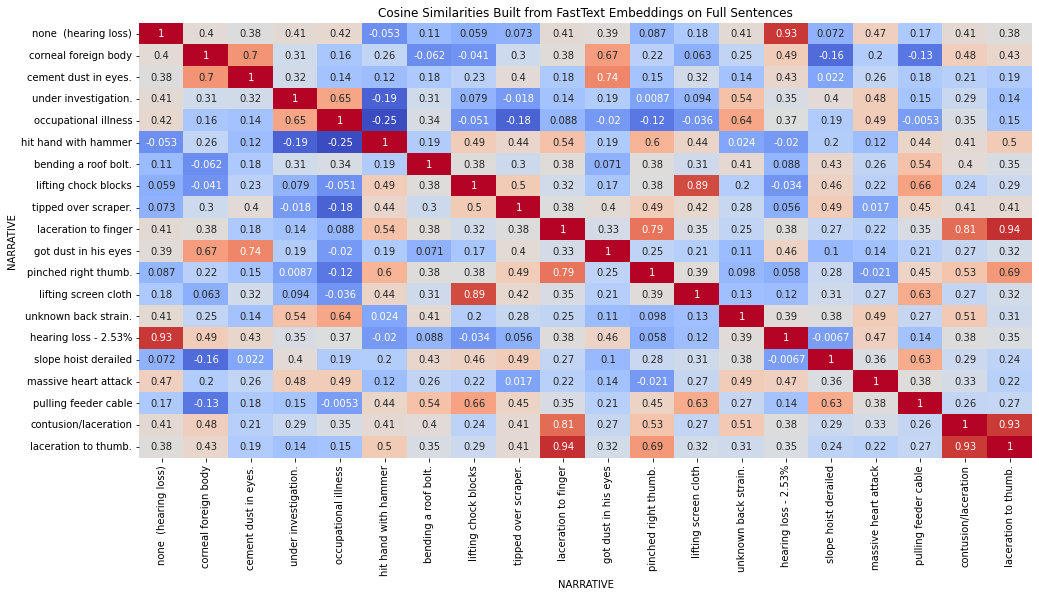

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
dfCS = pd.DataFrame(cosine_similarity(dfSampleVec), index=dfSampleVec.index, columns=dfSampleVec.index)
plt.rcParams['figure.figsize'] = [16, 8]   # plot wider figures
ax = sns.heatmap(dfCS, annot=True, cmap='coolwarm', cbar=False);
tmp = ax.set_title('Cosine Similarities Built from FastText Embeddings on Full Sentences');

The cosine similarities close to 1 (dark red) indicate semantically similar narratives, while dark blue indicate semantically dissimilar narratives. You can evaluate these for yourself by identifying a few dark red and dark blue cells. 
 
The diagonal values are not useful because they are always 1, since any sentence or document is perfectly semantically similar to itself.

## **Search for Semantic Similarity in a Document**

Next, you will use a query vector to find narratives, which are semantically related to the corresponding query string. For that, you will need to convert each narrative to a numeric vector and sort the vectors by their cosine similarity to the query vector.
 
Below, compute cosine similarity for every narrative in a sample and order these narratives by decreasing cosine similarity so that the most semantically similar narratives are at the top.

In [6]:
sQuery = 'fell down the stairs'
vQuery = ft.wv[sQuery]
%time dfDocs['CS'] = dfDocs.NARRATIVE.head(1000).apply(lambda s: CS(ft.wv[s],vQuery))
dfDocs.sort_values('CS', ascending=False).head(10)

CPU times: user 3.56 s, sys: 6.64 ms, total: 3.57 s
Wall time: 3.57 s


,NARRATIVE,CS
117195,"end of the shift, ee was climbing down a the equipment ladder of a cat 777 end dump truck. ee didnt use lunch box rope. when ee climbed down to the bumper, ee moved ee's lunch box from the radiator down to the bumper with ee's left hand. when ee started to climb down, ee lost grip with ee's right hand before ee could gain grip with ee's left hand. ee fell approximately five feet.",0.73
96408,contractor ee was walking down a set of metal stair steps and he thought that he was at the bottom of the stairs when he missed the last step. he lost his balance as he stepped forward to rega in his balance. as he stepped forward to regain his balance his left leg/ankle swung backward striking the leading edge of a step. contractor sustained a laceration on the back of his ankle j,0.71
...,...,...
110447,"the ee had parked the endloader next to diesel fueling station & was descending the outside ladder from cab when accident occurred. as ee was making his way to the ground, his rt foot slipped off ladder rung while his lt foot & hand were in motion causing his full body weight onto his rt shoulder & arm which was still clinging to ladder. ee quickly caught his footing & proceeded do",0.67
29863,ee heard a noise in the truck shop so he unlocked it & went inside to check it out & a man came full force at him. employee pushed him away & then the man punched him in the nose. ee hit him 2 or 3 times in the face with his fist & the man landed on the floor. ee put his knee on his back & heard footsteps behind him then was hit in the head. he was unconscious for about 40 minutes,0.67


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

Now, equipped with these concepts and tools, you will tackle a few related tasks.

As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

# Task 1
 
Use the `sQuery = 'loss of hearing'` query string to find semantically related incidents in the `dfDocs.NARRATIVE.head(10000)`. Then, read the "most relevant" narratives and decide on how many are related to the query. What cosine similarity threshold would you use to cut off all unrelated narratives?

 <b>Hint:</b> This is similar to the search above.

In [ ]:
# check solution here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
sQuery = 'loss of hearing'
vQuery = ft.wv[sQuery]
%time dfDocs['CS'] = dfDocs.NARRATIVE.head(10000).apply(lambda s: CS(ft.wv[s],vQuery))
dfDocs.sort_values('CS', ascending=False).head(10)</pre>
 
One challenge with cosine similarity is determining the cut-off threshold. This requires domain expertise, i.e., reading the narratives and making a decision on where the related reports end and unrelated reports begin. Later we will learn additional tools that help us in this unsupervised task.</details>
</font>

# Task 2

Train the FastText model on a larger set of narratives (say, 15,000) in several different ways: for more or fewer epochs and with smaller/larger vector sizes. You can subjectively evaluate the quality of each trained FastText model by observing the relatedness of the results for your `sQuery` above. 

<b>Hint:</b> This is similar to the training above but with different parameters and longer MSHA text.

In [ ]:
# check solution here

<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
<pre>
dfDocs1 = dfAll.sort_values('Len', ascending=False).head(15000)[['NARRATIVE']] # keep longest 15000 narratives
nlp = English(disable=['tagger', 'parser', 'ner'])           # disabled models save processing time in Spacy
tokenize = lambda text: [t.text.lower() for t in nlp(text)]  # sentences string -> produces a list of tokens
dfTok1 = dfDocs1['NARRATIVE'].apply(tokenize).to_frame()
%time ft = FastText(sentences=dfTok1.NARRATIVE, vector_size=25, workers=16, epochs=20)  # train model</pre>
 
This is just one way to retrain the FastText model with 15K sentences and shorter vectors over 20 epochs. Evaluation of the quality of such vectors is needed. One can subjectively assess the model's ability to relate text excerpts. Alternatively, a metric can be used to automate the assessment of such models if many different model variants are tried.</details>
</font>